In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [22]:
k = 1

In [23]:
def f(x):
    return tf.sin(k * x[:, 0:1]) * tf.cos(k * x[:, 1:2])

In [24]:
def func(x):
    return -np.sin(k * x[:, 0:1]) * np.cos(k * x[:, 1:2]) / (k * k)

In [25]:
def u_exact(x, y):
    return -np.sin(k * x) * np.cos(k * y) / (k * k)

In [26]:
def g(x):
    return -np.sin(k * x[:, 0:1]) * np.cos(k * x[:, 1:2]) / (k * k)

In [7]:
def boundary_condition(x, on_boundary):
    return on_boundary


def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    return - (u_xx + u_yy) - f(x)

In [8]:
def compute_error_metrics(u_pred, u_exact_vals):
    l2_error = np.linalg.norm(u_pred - u_exact_vals) / np.linalg.norm(u_exact_vals)
    c_error = np.max(np.abs(u_pred - u_exact_vals))
    return l2_error, c_error


def compute_residual_norm(model, test_points):
    residuals = np.abs(model.predict(test_points, operator=pde))
    l2_residual = np.linalg.norm(residuals)
    c_residual = np.max(residuals)
    return l2_residual, c_residual

Compiling model...
'compile' took 0.002907 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.75e-01, 1.10e+00]    [1.81e-01, 1.10e+00]    [2.07e+00]    
Epoch 1: train loss improved from inf to 1.28e+00, saving model to model-1.weights.h5 ...

1000      [1.08e-03, 2.92e-03]    [7.21e-04, 2.92e-03]    [3.42e-01]    
Epoch 1000: train loss improved from 1.28e+00 to 4.00e-03, saving model to model-1000.weights.h5 ...

2000      [2.02e-04, 5.59e-04]    [1.25e-04, 5.59e-04]    [3.32e-01]    
Epoch 2000: train loss improved from 4.00e-03 to 7.61e-04, saving model to model-2000.weights.h5 ...

3000      [9.39e-05, 1.69e-04]    [6.69e-05, 1.69e-04]    [3.26e-01]    
Epoch 3000: train loss improved from 7.61e-04 to 2.62e-04, saving model to model-3000.weights.h5 ...

4000      [5.60e-05, 1.22e-04]    [3.99e-05, 1.22e-04]    [3.26e-01]    
Epoch 4000: train loss improved from 2.62e-04 to 1.78e-04, saving model to model-4000.weights.h5 ...

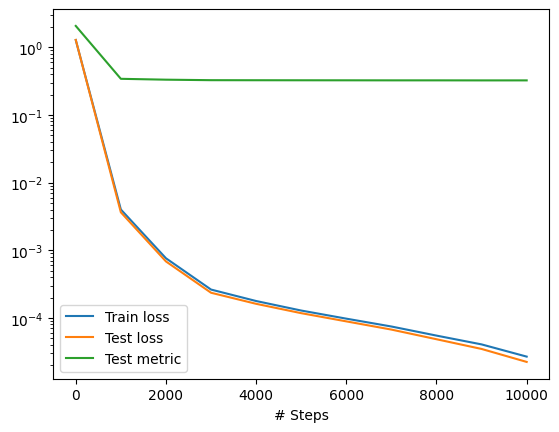

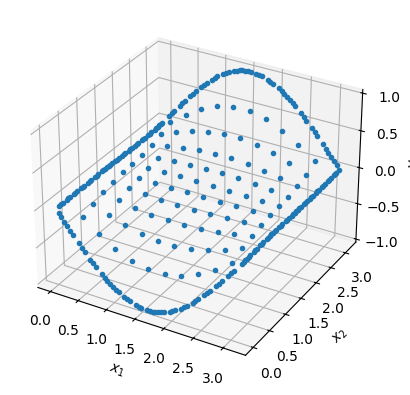

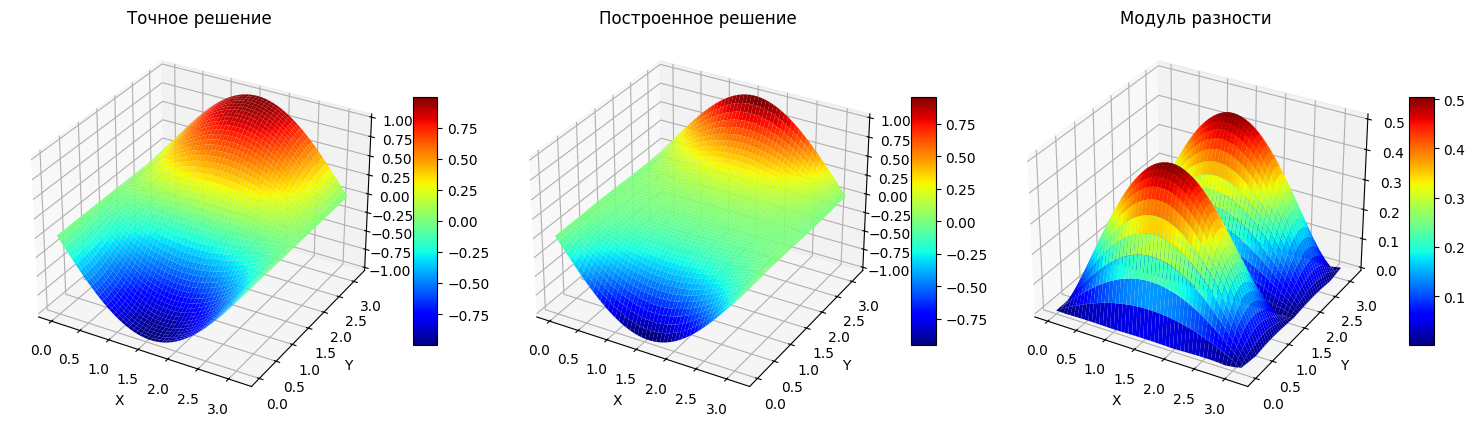

In [27]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=2000, num_boundary=200, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    
    checkpointer = dde.callbacks.ModelCheckpoint(
        "model", verbose=1, save_better_only=True
    )
    losshistory, train_state = model.train(iterations=N, callbacks=[checkpointer])

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 1000), np.linspace(0, np.pi, 1000))
    X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T

    u_pred = model.predict(X_test_flat).reshape(X_test.shape)

    u_exact_vals = u_exact(X_test, Y_test)
    
    fig = plt.figure(figsize=(15, 10))

    # 3D график для точного решения
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(X_test, Y_test, u_exact_vals, cmap="jet")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
    ax1.set_title("Точное решение")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u_exact')

    # 3D график для построенного решения
    ax2 = fig.add_subplot(232, projection='3d')
    surf2 = ax2.plot_surface(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
    ax2.set_title("Построенное решение")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u_pred')

    # 3D график для модуля разности
    ax3 = fig.add_subplot(233, projection='3d')
    surf3 = ax3.plot_surface(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
    ax3.set_title("Модуль разности")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('|u_pred - u_exact|')

    plt.tight_layout()
    plt.show()
    
    '''fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('auto')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()'''
    
    return

poisson_pinn(10000)

Compiling model...
'compile' took 0.003566 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.75e-01, 8.20e-01]    [1.81e-01, 8.20e-01]    [3.57e+00]    
Epoch 1: train loss improved from inf to 9.95e-01, saving model to model-1.weights.h5 ...

1000      [2.43e-03, 3.21e-03]    [1.44e-03, 3.21e-03]    [4.82e-01]    
Epoch 1000: train loss improved from 9.95e-01 to 5.64e-03, saving model to model-1000.weights.h5 ...

2000      [2.92e-04, 3.36e-04]    [2.26e-04, 3.36e-04]    [4.43e-01]    
Epoch 2000: train loss improved from 5.64e-03 to 6.28e-04, saving model to model-2000.weights.h5 ...

3000      [1.21e-04, 1.37e-04]    [8.68e-05, 1.37e-04]    [4.38e-01]    
Epoch 3000: train loss improved from 6.28e-04 to 2.58e-04, saving model to model-3000.weights.h5 ...

4000      [6.05e-05, 8.57e-05]    [3.60e-05, 8.57e-05]    [4.35e-01]    
Epoch 4000: train loss improved from 2.58e-04 to 1.46e-04, saving model to model-4000.weights.h5 ...

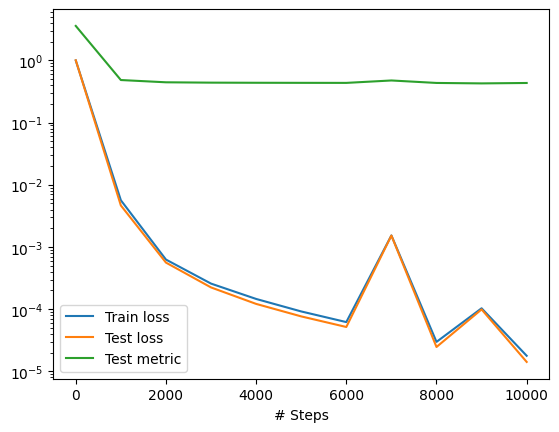

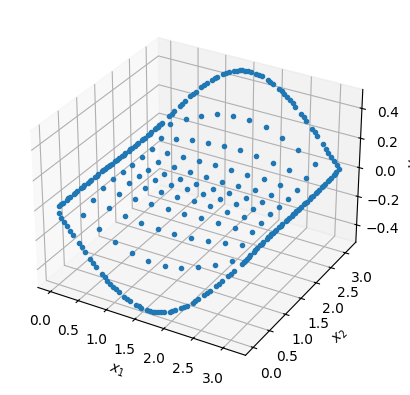

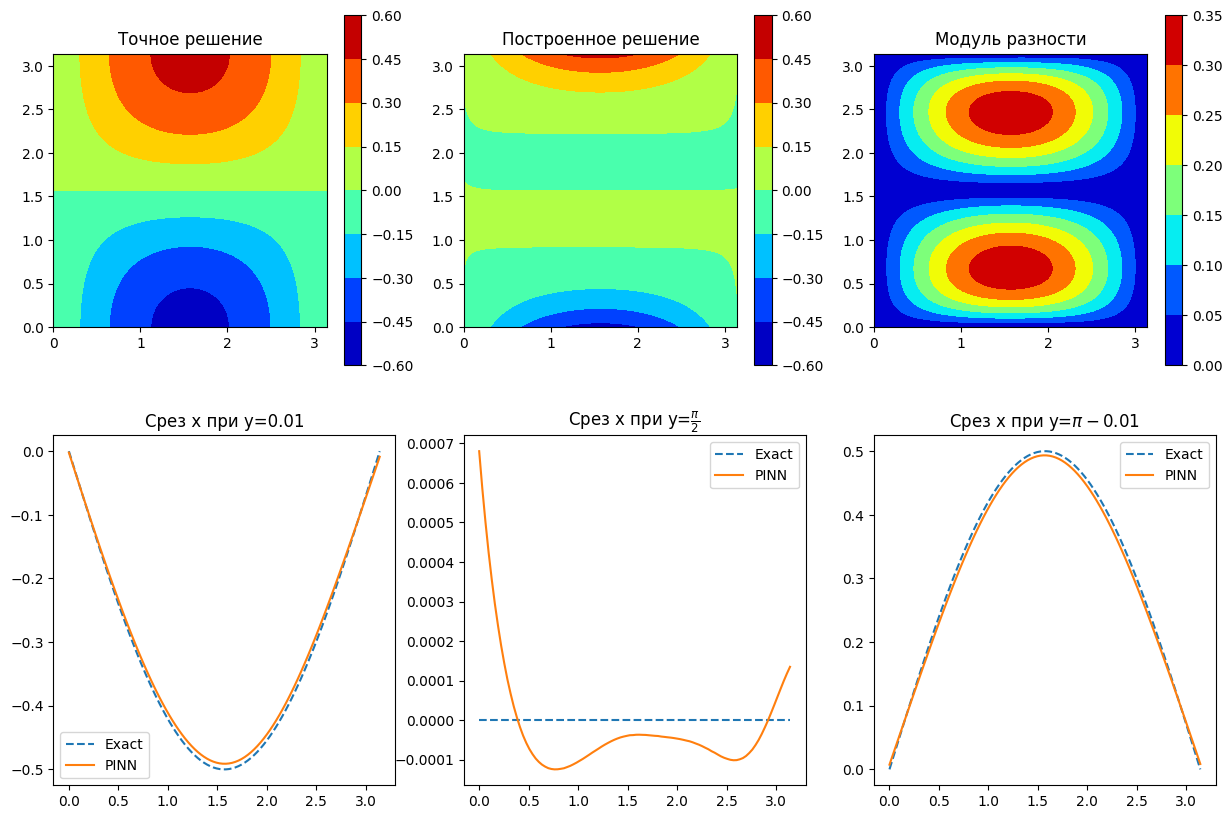

In [ ]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=2000, num_boundary=200, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model.train(iterations=N)

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 1000), np.linspace(0, np.pi, 1000))
    X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T

    u_pred = model.predict(X_test_flat).reshape(X_test.shape)

    u_exact_vals = u_exact(X_test, Y_test)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('auto')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()

poisson_pinn(10000)

Compiling model...
'compile' took 0.002830 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.27e-01, 6.63e-01]    [3.28e-01, 6.63e-01]    [1.59e+02]    
Epoch 1: train loss improved from inf to 9.90e-01, saving model to model-1.weights.h5 ...

1000      [2.49e-01, 4.94e-05]    [2.48e-01, 4.94e-05]    [1.28e+00]    
Epoch 1000: train loss improved from 9.90e-01 to 2.50e-01, saving model to model-1000.weights.h5 ...

2000      [2.21e-01, 1.64e-04]    [2.30e-01, 1.64e-04]    [2.21e+00]    
Epoch 2000: train loss improved from 2.50e-01 to 2.21e-01, saving model to model-2000.weights.h5 ...

3000      [7.96e-02, 2.05e-04]    [7.38e-02, 2.05e-04]    [2.42e+00]    
Epoch 3000: train loss improved from 2.21e-01 to 7.98e-02, saving model to model-3000.weights.h5 ...

4000      [4.65e-03, 5.04e-05]    [2.72e-03, 5.04e-05]    [1.17e+00]    
Epoch 4000: train loss improved from 7.98e-02 to 4.70e-03, saving model to model-4000.weights.h5 ...

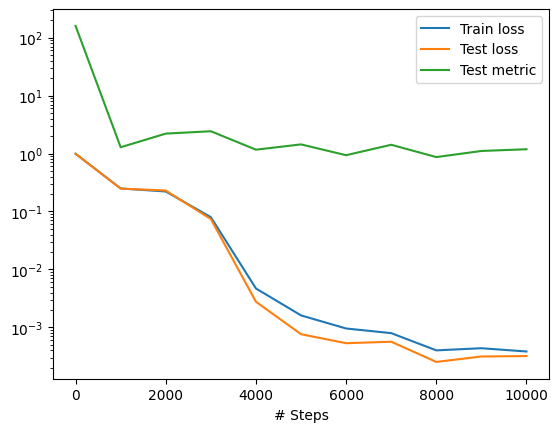

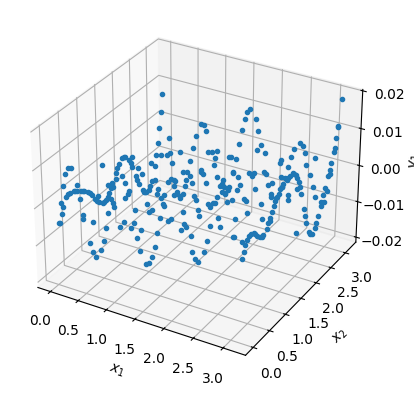

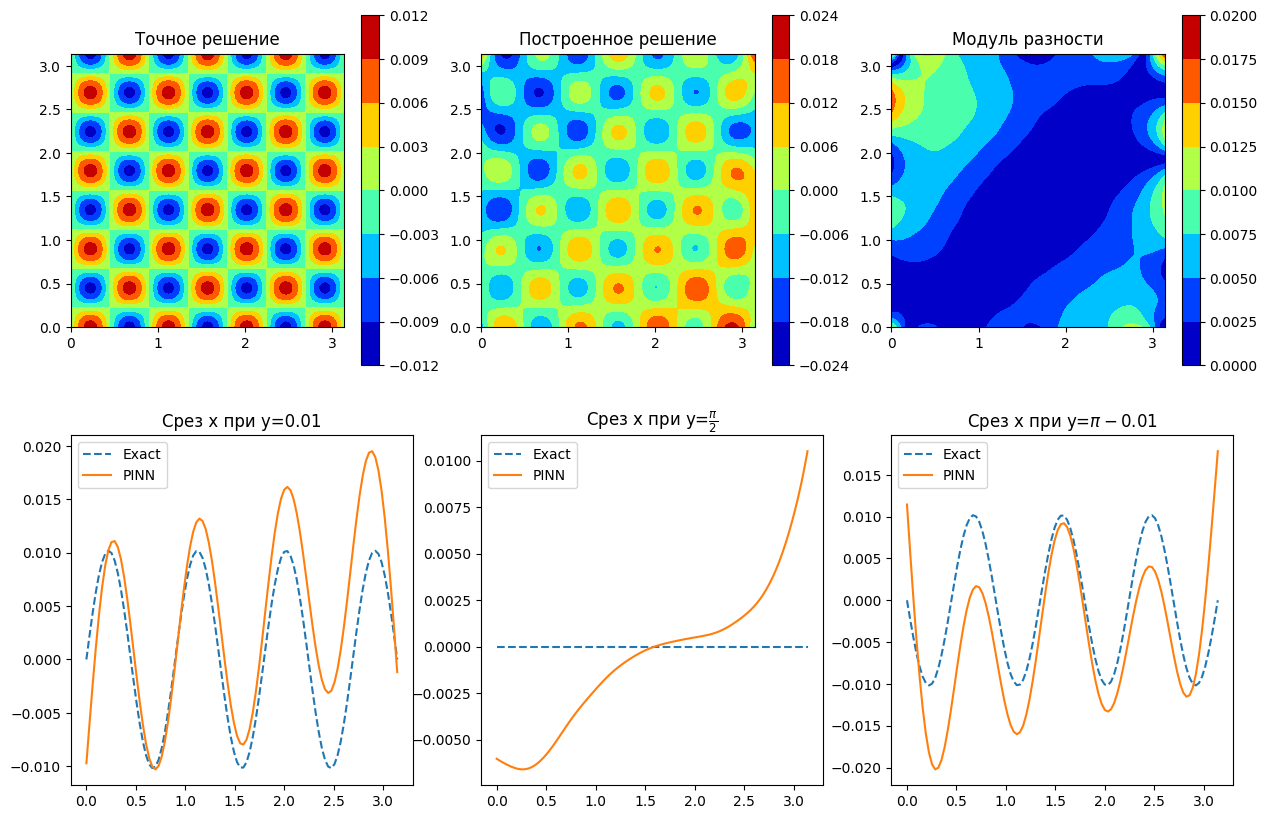

In [ ]:
poisson_pinn(10000)

Compiling model...
'compile' took 0.002424 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.28e-01, 6.63e-01]    [3.28e-01, 6.63e-01]    [7.21e+02]    
Epoch 1: train loss improved from inf to 9.91e-01, saving model to model-1.weights.h5 ...

1000      [2.51e-01, 1.16e-05]    [2.47e-01, 1.16e-05]    [2.66e+00]    
Epoch 1000: train loss improved from 9.91e-01 to 2.51e-01, saving model to model-1000.weights.h5 ...

2000      [2.51e-01, 6.30e-06]    [2.47e-01, 6.30e-06]    [1.99e+00]    
Epoch 2000: train loss improved from 2.51e-01 to 2.51e-01, saving model to model-2000.weights.h5 ...

3000      [2.49e-01, 2.71e-05]    [2.47e-01, 2.71e-05]    [3.99e+00]    
Epoch 3000: train loss improved from 2.51e-01 to 2.49e-01, saving model to model-3000.weights.h5 ...

4000      [2.45e-01, 1.05e-05]    [2.48e-01, 1.05e-05]    [2.56e+00]    
Epoch 4000: train loss improved from 2.49e-01 to 2.45e-01, saving model to model-4000.weights.h5 ...

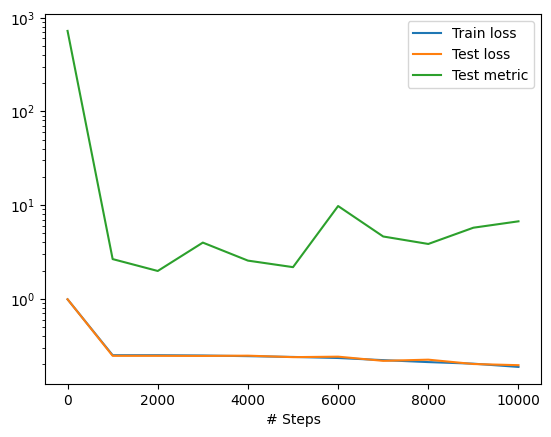

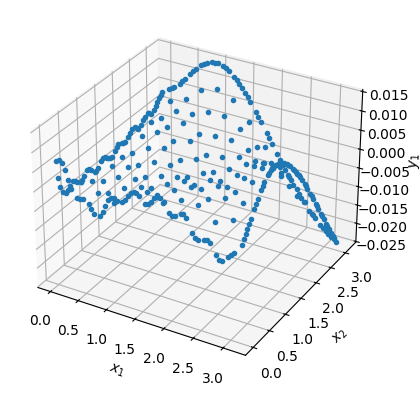

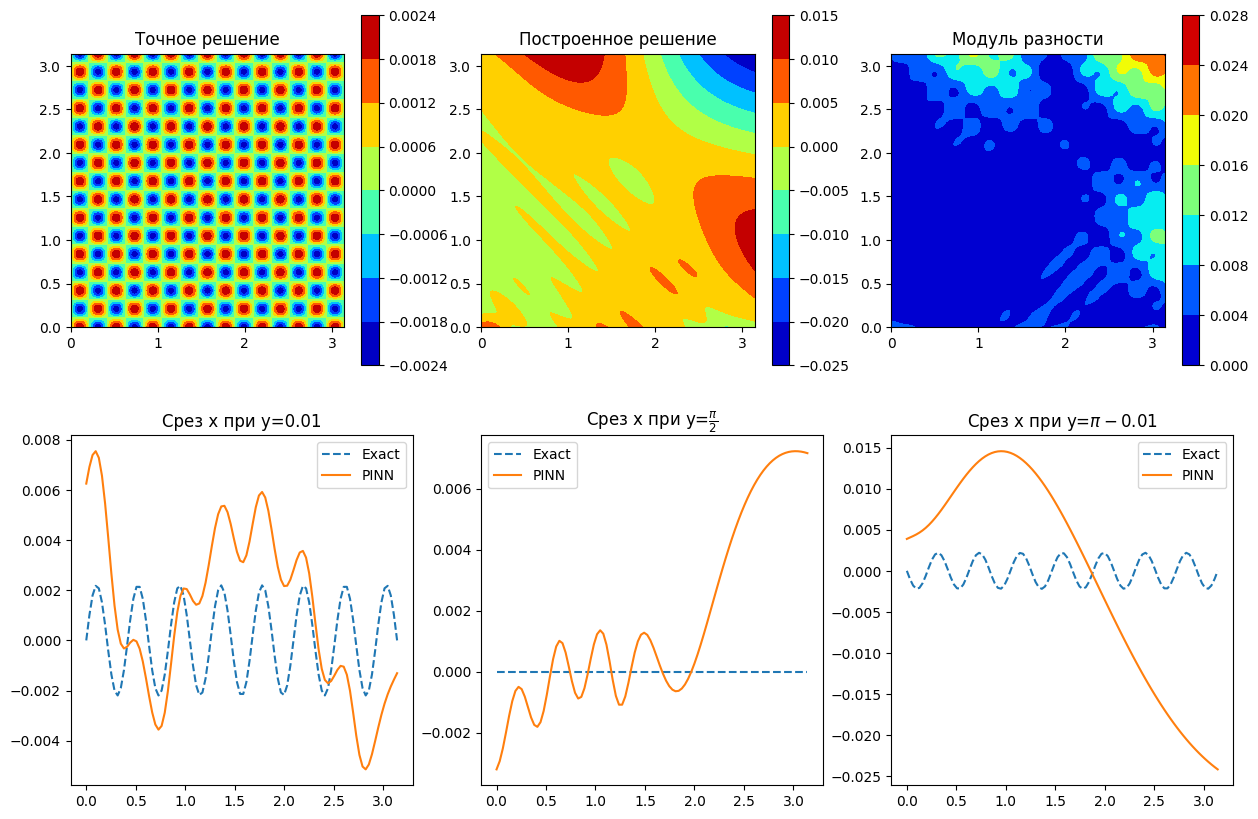

In [ ]:
poisson_pinn(10000)

In [12]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=1000, num_boundary=100, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    
    u_pred_list = []
    for i in range(0, N+1, 500):
        model.train(iterations=i, display_every=500)
        X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 100), np.linspace(0, np.pi, 100))
        X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T
        u_pred = model.predict(X_test_flat).reshape(X_test.shape)
        u_pred_list.append(u_pred)
    
    u_exact_vals = u_exact(X_test, Y_test)
    
    l2_error, c_error = compute_error_metrics(u_pred, u_exact_vals)
    l2_residual, c_residual = compute_residual_norm(model, X_test_flat)
    
    print(f"L2 error: {l2_error}, C error: {c_error}")
    print(f"L2 residual norm: {l2_residual}, C residual norm: {c_residual}")
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('equal')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()
    
    fig_anim, ax_anim = plt.subplots()
    def update_anim(frame):
        ax_anim.clear()
        cs = ax_anim.contourf(X_test, Y_test, u_pred_list[frame], cmap="jet")
        return cs.collections
    
    ani = animation.FuncAnimation(fig_anim, update_anim, frames=len(u_pred_list), interval=200)
    ani.save("pinn_solution_evolution.gif", writer="ffmpeg")
    
    return l2_error, c_error, l2_residual, c_residual

poisson_pinn(5000)

Compiling model...
'compile' took 0.002803 s

Training model...

0         [1.33e-01, 2.89e-01]    [1.72e-01, 2.89e-01]    [2.32e+00]    

Best model at step 0:
  train loss: 4.22e-01
  test loss: 4.61e-01
  test metric: [2.32e+00]

'train' took 0.437227 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.33e-01, 2.89e-01]    [1.72e-01, 2.89e-01]    [2.32e+00]    
500       [4.07e-03, 2.73e-03]    [2.76e-03, 2.73e-03]    [2.02e-01]    

Best model at step 500:
  train loss: 6.80e-03
  test loss: 5.49e-03
  test metric: [2.02e-01]

'train' took 2.278452 s

Training model...

Step      Train loss              Test loss               Test metric   
500       [4.07e-03, 2.73e-03]    [2.76e-03, 2.73e-03]    [2.02e-01]    


KeyboardInterrupt: 